In [ ]:
import os, sys
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from config_local import local_config

In [ ]:
train = pd.read_csv(local_config.TRAIN_CSV)
test  = pd.read_csv(local_config.TEST_CSV)

print(f"Train shape: {train.shape}  |  Test shape: {test.shape}")
display(train.head(3))

Train shape: (1460, 81)  |  Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [ ]:
candidate_numeric = ['GrLivArea', 'OverallQual', 'YearBuilt', 'GarageCars', 'FullBath', 'TotRmsAbvGrd']
features = [f for f in candidate_numeric if f in train.columns and f in test.columns]

X = train[features].copy()
y = train['SalePrice'].copy()
X_test = test[features].copy()

print("Features:", features)

Features: ['GrLivArea', 'OverallQual', 'YearBuilt', 'GarageCars', 'FullBath', 'TotRmsAbvGrd']


In [ ]:
for c in features:
    med = X[c].median()
    X[c] = X[c].fillna(med)
    X_test[c] = X_test[c].fillna(med)

# Check
assert not X.isna().any().any()
assert not X_test.isna().any().any()

In [ ]:
model = LinearRegression()
model.fit(X, y)

pred_train = model.predict(X)
rmse = mean_squared_error(y, pred_train)

print("Intercept:", model.intercept_)
print("Coefficients:", dict(zip(features, model.coef_)))
print(f"Train RMSE: {rmse:,.0f}")

Intercept: -876953.2020075064
Coefficients: {'GrLivArea': np.float64(65.44783821804151), 'OverallQual': np.float64(22881.33945895374), 'YearBuilt': np.float64(412.80036748684506), 'GarageCars': np.float64(16361.60654650769), 'FullBath': np.float64(-8603.357566266395), 'TotRmsAbvGrd': np.float64(-1543.1769429315173)}
Train RMSE: 1,562,963,453


In [ ]:
pred_test = model.predict(X_test)

submission = pd.DataFrame({
    "Id": test["Id"],
    "SalePrice": pred_test
})

os.makedirs(local_config.SUBMISSIONS_DIR, exist_ok=True)
out_path = os.path.join(local_config.SUBMISSIONS_DIR, "naive_lr.csv")
submission.to_csv(out_path, index=False)

print(f"Submission saved -> {out_path}")
submission.head()

Submission saved -> d:\Project\Kaggle\house-prices-starter\submissions\naive_lr.csv


,Id,SalePrice
0,1461,105638.643238
1,1462,154077.318600
2,1463,174687.793919
3,1464,194802.560847
4,1465,219969.691863


<Axes: >

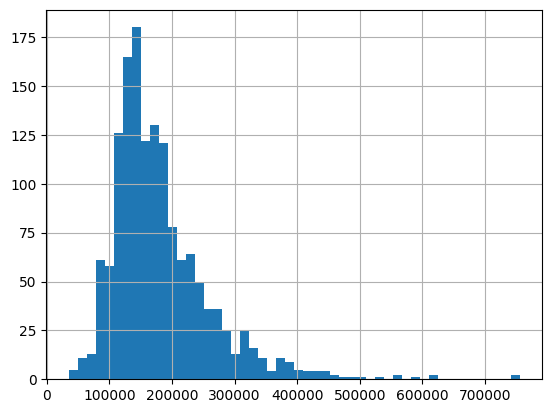

In [ ]:
train['SalePrice'].hist(bins=50)

The law of distribution of sale prices looks like it is following a log normal distribution? shall we try to find the law of the sale prices

Shapiro-Wilk test: ShapiroResult(statistic=np.float64(0.9912067503807811), pvalue=np.float64(1.1490615527264654e-07))
Anderson-Darling test: AndersonResult(statistic=np.float64(3.5387544749892186), critical_values=array([0.574, 0.654, 0.785, 0.916, 1.089]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=np.float64(12.024050901109383), scale=np.float64(0.39945186826116424))
 success: True
 message: '`anderson` successfully fit the distribution to the data.')


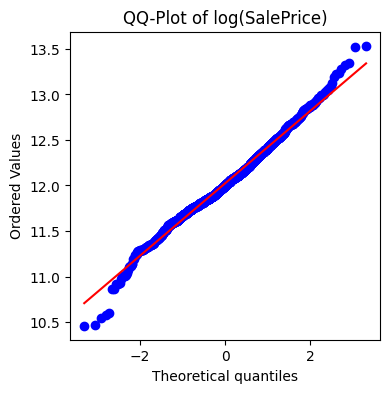

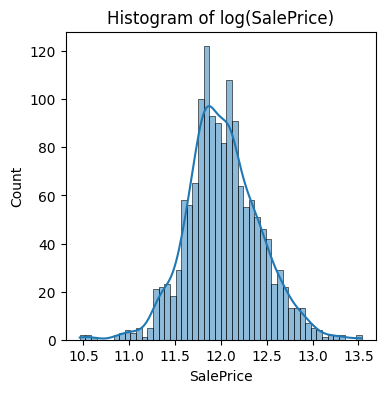

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# Take log of SalePrice
log_prices = np.log(train['SalePrice'])

# --- 1. Shapiro-Wilk test ---
shapiro_test = stats.shapiro(log_prices)
print("Shapiro-Wilk test:", shapiro_test)
# p > 0.05 → data is not significantly different from Normal

# --- 2. Anderson-Darling test ---
anderson_test = stats.anderson(log_prices, dist='norm')
print("Anderson-Darling test:", anderson_test)
# Check statistic vs critical values: if statistic < critical value → likely Normal

# --- 3. QQ-plot ---
plt.figure(figsize=(4,4))
stats.probplot(log_prices, dist="norm", plot=plt)
plt.title("QQ-Plot of log(SalePrice)")
plt.show()

# --- 4. Histogram with KDE ---
plt.figure(figsize=(4,4))
sns.histplot(log_prices, bins=50, kde=True)
plt.title("Histogram of log(SalePrice)")
plt.show()

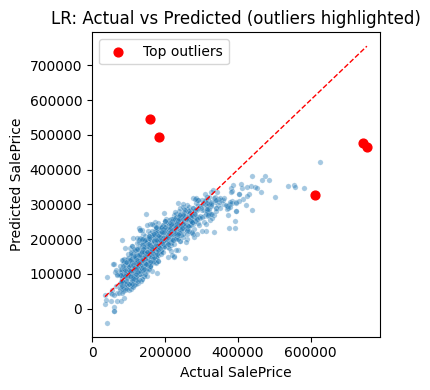

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(4,4))
sns.scatterplot(x=y, y=pred_train, alpha=0.4, s=15)

residuals = y - pred_train

train_results = train.copy()
train_results['Predicted'] = pred_train
train_results['Residual'] = residuals

outliers = train_results.reindex(residuals.abs().sort_values(ascending=False).index)

# Mark top 5 outliers in red
top_outliers = outliers.head(5)
plt.scatter(top_outliers['SalePrice'], top_outliers['Predicted'],
            color='red', s=40, label="Top outliers")

plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=1)
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("LR: Actual vs Predicted (outliers highlighted)")
plt.legend()
plt.tight_layout()
plt.show()

The actual naive linear regression overstimate cheap priced house, while in underestimate expensive house. This is mainly due to the relation shipbetween the actual price and the predicted one **not** having a linear law.

In [ ]:
top_outliers_features = top_outliers[features + ['SalePrice', 'Predicted', 'Residual']]
display(top_outliers_features)

,GrLivArea,OverallQual,YearBuilt,GarageCars,FullBath,TotRmsAbvGrd,SalePrice,Predicted,Residual
1298,5642,10,2008,2,2,12,160000,547018.408367,-387018.408367
523,4676,10,2007,3,3,11,184750,492684.422204,-307934.422204
691,4316,10,1994,3,3,10,755000,465299.972611,289700.027389
898,2364,9,2009,3,2,11,611657,327916.639086,283740.360914
1182,4476,10,1996,3,3,10,745000,476597.227461,268402.772539


In [ ]:
train_full = train.copy()

# Add model outputs
train_full['Predicted'] = pred_train
train_full['Residual'] = residuals
train_full['AbsResidual'] = residuals.abs()
# Sort by absolute residual
outliers_full = train_full.sort_values(by='AbsResidual', ascending=False)

# Show top 10 outliers with ALL columns
outliers_full.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Predicted,Residual,AbsResidual
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,NaN,0,1,2008,New,Partial,160000,547018.408367,-387018.408367,387018.408367
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,NaN,0,10,2007,New,Partial,184750,492684.422204,-307934.422204,307934.422204
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,1,2007,WD,Normal,755000,465299.972611,289700.027389,289700.027389
898,899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,3,2010,New,Partial,611657,327916.639086,283740.360914,283740.360914
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,7,2007,WD,Abnorml,745000,476597.227461,268402.772539,268402.772539
803,804,60,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,1,2009,New,Partial,582933,347332.414114,235600.585886,235600.585886
1046,1047,60,RL,85.0,16056,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,7,2006,New,Partial,556581,350647.790512,205933.209488,205933.209488
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,...,NaN,0,7,2006,WD,Normal,625000,420619.212447,204380.787553,204380.787553
440,441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,...,NaN,0,4,2009,WD,Normal,555000,354415.372973,200584.627027,200584.627027
769,770,60,RL,47.0,53504,Pave,NaN,IR2,HLS,AllPub,...,NaN,0,6,2010,WD,Normal,538000,352296.734883,185703.265117,185703.265117


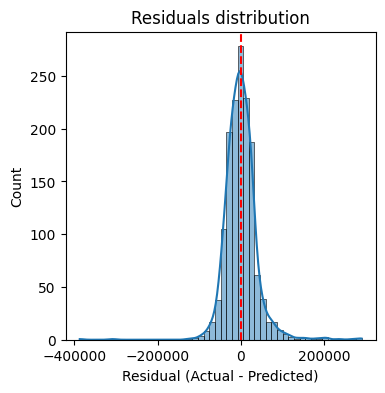

In [ ]:

plt.figure(figsize=(4,4))
sns.histplot(residuals, bins=50, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel("Residual (Actual - Predicted)")
plt.title("Residuals distribution")
plt.show()

Usual gaussian shaped of residuals, this let us think that on average the model is predicting fine. However, looking at the tales, as shown above, some prices are having misspricing by hundred of thousands of dollars. Meaning that the law of the residuals are having fat tails which the model can't explain. Outliers have a big impact.

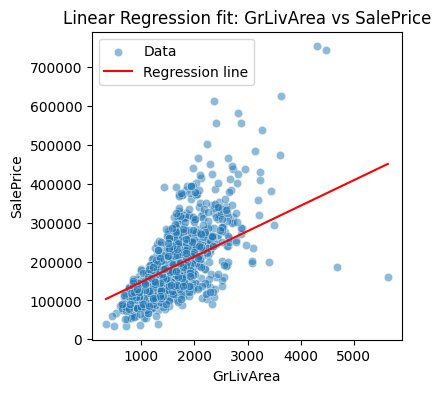

In [ ]:
plt.figure(figsize=(4,4))
sns.scatterplot(x=X['GrLivArea'], y=y, alpha=0.5, label="Data")

# Regression line: y = coef*X + intercept (keeping other features at mean)
coef = model.coef_[features.index('GrLivArea')]
intercept = model.intercept_ + sum(
    model.coef_[i] * X[features[i]].mean() 
    for i in range(len(features)) if features[i] != 'GrLivArea'
)

x_line = np.linspace(X['GrLivArea'].min(), X['GrLivArea'].max(), 100)
y_line = coef * x_line + intercept

plt.plot(x_line, y_line, color="red", label="Regression line")
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.title("Linear Regression fit: GrLivArea vs SalePrice")
plt.legend()
plt.show()

This means that as the house has more ground living area, the pricier it is. Logic. However some house sold at a very cheap price which is unusual. Line underestimates expensive small/medium homes

For smaller houses (~1000–2000 sq ft), some sold very high → your line is too low there.

That shows size alone doesn’t explain luxury or location premiums.